<a href="https://colab.research.google.com/github/stafd/style-transfer/blob/master/Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hi, here!

# 你好

You are viewing the page to create your own style of images. To continue, we suppose you have some basic knowledge of Python, a kind of coding language. If you really do not have it, things may get strange when you face different errors.

你正在浏览的页面能够帮助你创建自己的风格迁移照片。开始之前，我们假设你已经有了一些基本 Python 知识，这在出现各种错误的时候将会帮助解决问题。

For starter users, what you need to do is simply click the Starting Buttom, and our instructions will help you.

对于入门者(不具有 Python 知识)，你只需要依照指示点按开始按钮即可。

If you come to any error, you can contact us by posting issues on our repository  on GitHub.

如果你遇到了任何问题，你可以在我们的 GitHub 仓库提出 issue。

### 注意

开始以前，我们建议你在**代码执行程序-更改运行时类型-硬件加速器**中设置为GPU

###Caution

Before you start, we highly recomend you to set a GPU in **Runtime - Change runtime type - Hardware**.

## PART 1 Use a pre-trained model to transfer

## 第一部分 使用预先训练好的模型

If you want to create another model, please come staright to PART 2(NOT SUPPORT NOW)

如果你希望创建自己的模型，请直接跳到第二部分(暂不支持)

First, you should maake sure that your connection to Google is stable, especially when in Mainland China.

我们建议你取得与 Google 服务器的稳定连接，尤其是当你在中国大陆境内。

In [0]:
# Tools installation
#@title Tools installation
!pip install git+https://www.github.com/keras-team/keras-contrib.git
!pip install keras==2.2.4
!wget https://www.cdqzsta.com/withkitual/style.h5

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-n_bvjj7s
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-n_bvjj7s
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101066 sha256=08d5a14d08c118046493411b55f5fc006765d322985d5b61c9a87ceae98b9cc3
  Stored in directory: /tmp/pip-ephem-wheel-cache-nnni7qwj/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
--2019-08-09 07:07:39--  https://www.cdqzsta.com/withkitual/style.h5
Resolving www.cdqzsta.com (www.cdqzsta.com)... 104.18.38.207
Connecting to www.cdqzsta.com (www.cdqzsta.com)|104.18.38.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 569552 (556K)
Saving to: ‘style.h5’

style.h5            100%[===================>] 556.20K  1.18MB/s    in 0.5s    

2019-08-09 07:07:40 (1.18 MB/s) - ‘style.h5’ saved [569552/569552]



In [0]:
# Working space preparation
#@title Working space preparation
!mkdir -p convert/data

In [0]:
# BASIC enironment
# layers
import keras


class VGGNormalize(keras.layers.Layer):
    """A custom layer to normalize an image for input into a VGG model.
    This consists of swapping channel order and centering pixel values.
    Centering values come from:
    https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/keras/_impl/keras/applications/imagenet_utils.py  # NOQA
    """
    #@markdown VGGNormalize是一个自定义层，对输入VGG的图片进行处理。
    #@markdown 你可以在[Github](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/keras/_impl/keras/applications/imagenet_utils.py) 找到更多

    def __init__(self, **kwargs):
        super(VGGNormalize, self).__init__(**kwargs)
        # work around for a bug introduced in diffences between the tf.keras and keras APIs
        self.outbound_nodes = self._outbound_nodes

    def build(self, input_shape):
        """Build the layer."""
        #创建一个层
        pass

    def call(self, x, reverse_channels=True):
        # x是输入的张量(你可以把它想象成向量)，如果是True，就交换顺序(相反)。
        # Swap channel order: 'RGB'->'BGR'
        if reverse_channels:
            x = x[:, :, :, ::-1]

        # 中心像素值。
        x -= 120.0

        return x


class DeprocessStylizedImage(keras.layers.Layer):
    """A layer to deprocess style transfer layer output.
    The style transfer network outputs an image where pixel values are
    between -1 and 1 due to a tanh activation. This layer converts that back
    to normal values between 0 and 255.
    """
    #@markdown DeprocessStylizedImage是一个输出层。
    #@markdown 通过样本输出网络以像素输出。
    
    

    def __init__(self, **kwargs):
      # 进行初始化。
        super(DeprocessStylizedImage, self).__init__(**kwargs)

    def build(self, input_shape):
        pass

    def call(self, x):
        return (x + 1.0) * 127.5

In [0]:
#utils
import io
import logging
import os

import PIL.Image
import numpy
from tensorflow.python.lib.io import file_io


logger = logging.getLogger('utils')


def load_image(
        filename,
        height,
        width,
        expand_dims=False):
    """我们载入图片以后，图片将是以numpy中四维的形式呈现。
    (你可能在后面看到数组越界或者 too many arrays 的错误，不用惊慌，先检查一下你的图片是否存在问题)
    expand_dims可以用来增加维度(训练模型时有用处)"""
    img = file_io.read_file_to_string(filename, binary_mode=True)
    img = PIL.Image.open(io.BytesIO(img))
    img = img.resize((width, height), resample=PIL.Image.BILINEAR)
    img = numpy.array(img)[:, :, :3]

    if expand_dims:
        img = numpy.expand_dims(img, axis=0)

    return img


def copy_file_from_gcs(file_path):
    logger.info('Downloading %s' % file_path)
    with file_io.FileIO(file_path, mode='rb') as input_f:
        basename = os.path.basename(file_path)
        with file_io.FileIO(basename, mode='w+') as output_f:
            output_f.write(input_f.read())
    return basename

In [0]:
#models
import keras
import keras_contrib
import logging


logger = logging.getLogger('models')


class StyleTransferNetwork(object):
    """A class that builds a Keras model to perform style transfer.
    The architecture for this model comes from Johnson et al:
    https://arxiv.org/abs/1603.08155
    https://cs.stanford.edu/people/jcjohns/papers/fast-style/fast-style-supp.pdf
    It differs slightly from Johnson's model by swapping reflective
    padding with Zero Padding and Batch Normalization for
    Instance Normalization as recommended in Ulyanov et al:
    https://arxiv.org/abs/1607.08022
    """
    #@markdown ###引用了三篇论文
    #@markdown [第一篇](https://arxiv.org/abs/1603.08155)    [第二篇](https://cs.stanford.edu/people/jcjohns/papers/fast-style/fast-style-supp.pdf)   [第三篇](https://arxiv.org/abs/1607.08022)

    @classmethod
    def build(
            cls,
            image_size,
            alpha=1.0,
            input_tensor=None,
            checkpoint_file=None):
        """Build a Transfer Network Model using keras' functional API.
        """
        #@markdown ####alpha是一个用于缩放通道数的参数，我们通过它控制我们选取的特征数目
        #@markdown 转换网络是按照 Keras 的函数式 API 实现的，网址在[Keras document](https://keras.io/zh/)
        x = keras.layers.Input(shape=(image_size[0], image_size[1], 3), tensor=input_tensor)
        out = cls._convolution(x, int(alpha * 32), 9, strides=1)
        out = cls._convolution(out, int(alpha * 64), 3, strides=2)
        out = cls._convolution(out, int(alpha * 128), 3, strides=2)
        out = cls._residual_block(out, int(alpha * 128))
        out = cls._residual_block(out, int(alpha * 128))
        out = cls._residual_block(out, int(alpha * 128))
        out = cls._residual_block(out, int(alpha * 128))
        out = cls._residual_block(out, int(alpha * 128))
        out = cls._upsample(out, int(alpha * 64), 3)
        out = cls._upsample(out, int(alpha * 32), 3)
        # out = keras.layers.ZeroPadding2D(padding=(1, 1))(out)
        out = cls._convolution(out, 3, 9, relu=False, padding='same')
        out = keras.layers.Activation('tanh')(out)
        # a custom layer for this in Core ML as well.
        out = DeprocessStylizedImage()(out)
        # out = layers.DeprocessStylizedImage()(out)
        model = keras.models.Model(inputs=x, outputs=out)

        # 从检查点导入
        if checkpoint_file:
            logger.info(
                'Loading weights from checkpoint: %s' % checkpoint_file
            )
            if checkpoint_file.startswith('gs://'):
                checkpoint_file = utils.copy_file_from_gcs(checkpoint_file)
            model.load_weights(checkpoint_file, by_name=True)
        return model

    @classmethod
    def _convolution(
            cls, x, n_filters, kernel_size, strides=1,
            padding='same', relu=True, use_bias=False):
        out = keras.layers.convolutional.Conv2D(
            n_filters,
            kernel_size,
            strides=strides,
            padding=padding,
            use_bias=use_bias
        )(x)

        # 实例规范化
        # We are using the keras-contrib library from @farizrahman4u for
        # an implementation of Instance Normalization. Note here that we are
        # specifying the normalization axis to be -1, or the channel axis.
        # By default this is None and simple Batch Normalization is applied.
        #他的GitHub主页是https://github.com/farizrahman4u
        out = keras_contrib.layers.InstanceNormalization(
            axis=-1)(out)
        if relu:
            out = keras.layers.Activation('relu')(out)
        return out

    @classmethod
    def _residual_block(cls, x, n_filters, kernel_size=3):
        # Make sure the layer has the proper size and store a copy of the
        # original, cropped input layer.
        # identity = keras.layers.Cropping2D(cropping=((2, 2), (2, 2)))(x)

        out = cls._convolution(x, n_filters, kernel_size, padding='same')
        out = cls._convolution(
            out, n_filters, kernel_size, padding='same', relu=False
        )
        out = keras.layers.Add()([out, x])
        return out

    @classmethod
    def _upsample(cls, x, n_filters, kernel_size, size=2):
        out = keras.layers.UpSampling2D(size=size)(x)
        # out = keras.layers.ZeroPadding2D(padding=(2, 2))(out)
        out = cls._convolution(out, n_filters, kernel_size, padding='same')
        return out


class SmallStyleTransferNetwork(StyleTransferNetwork):

    @classmethod
    def build(cls, image_size, alpha=1.0, input_tensor=None, checkpoint_file=None):
    # 控制模型的大小，帮助我们转换到 TensorFlow Lite 上并流畅应用。
    # 理想状态下我们能够把模型控制到 1M 以下，并且能够在移动设备的一些 GPU 上实现”实时风格迁移“
    # 使用了 Keras 的函数式 API。
        x = keras.layers.Input(
            shape=(image_size[0], image_size[1], 3), tensor=input_tensor)
        out = cls._convolution(x, int(alpha * 32), 9, strides=1)
        out = cls._convolution(out, int(alpha * 32), 3, strides=2)
        out = cls._convolution(out, int(alpha * 32), 3, strides=2)
        out = cls._residual_block(out, int(alpha * 32))
        out = cls._residual_block(out, int(alpha * 32))
        out = cls._residual_block(out, int(alpha * 32))
        out = cls._upsample(out, int(alpha * 32), 3)
        out = cls._upsample(out, int(alpha * 32), 3)
        out = cls._convolution(out, 3, 9, relu=False, padding='same')
        # Restrict outputs of pixel values to -1 and 1.
        out = keras.layers.Activation('tanh')(out)
        # Deprocess the image into valid image data. Note we'll need to define
        # a custom layer for this in Core ML as well.
        # out = layers.DeprocessStylizedImage()(out)
        out = DeprocessStylizedImage()(out)
        model = keras.models.Model(inputs=x, outputs=out)

        # Optionally load weights from a checkpoint
        if checkpoint_file:
            logger.info(
                'Loading weights from checkpoint: %s' % checkpoint_file
            )
            if checkpoint_file.startswith('gs://'):
                checkpoint_file = utils.copy_file_from_gcs(checkpoint_file)
            model.load_weights(checkpoint_file, by_name=True)
        return model


class IntermediateVGG(object):
    """A VGG network class that allows easy access to intermediate layers.
    This class takes the default VGG16 application packaged with Keras and
    constructs a dictionary mapping layer names to layout puts so that
    we can easily extract the network's features at any level. These outputs
    are used to compute losses in artistic style transfer.
    """
    """#@markdown ####IntermediateVGG是一个帮助你更容易访问到中间层网络类。
    #@markdown 这个类使用了默认的用Keras打包的VGG16，并且创建了一个字典映射到layout puts。
    #@markdown 这样，我们能够容易地提取到任何层的特征。
    #@markdown 这些输出 是用来计算风格迁移中损失函数的。"""

    def __init__(self, prev_layer=None, input_tensor=None):
        # prev_layer 能够帮助缝合不同模型
        # Create the Keras VGG Model
        self.model = keras.applications.vgg16.VGG16(
            weights='imagenet',
            include_top=False,
            input_tensor=input_tensor
        )

        # Make sure none of the VGG layers are trainable
        for layer in self.model.layers:
            layer.trainable = False

        # if a previous layer is specified, stitch that layer to the
        # input of the VGG model and rewire the entire model.
        self.layers = {}
        if prev_layer is not None:
            # We need to apply all layers to the output of the style net
            in_layer = prev_layer
            for layer in self.model.layers[1:]:  # Ignore the input layer
                in_layer = layer(in_layer)
                self.layers[layer.name] = in_layer
        else:
            self.layers = dict(
                [(layer.name, layer.output) for layer in self.model.layers]
            )

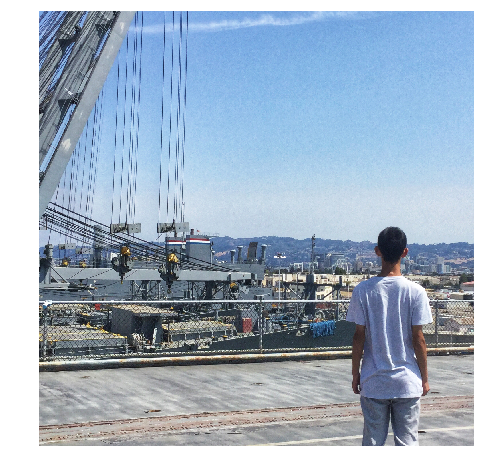

In [0]:
#@markdown Input the URL of your image. You can upload it in https://sm.ms , then copy the string to the textbox. We suggest it should be a square, for the best performance of our Style Transfer. If you have no picture, you can just ignore this instruction.

#@markdown 在此处输入你需要转化的图片地址。你可以先在 https://sm.ms 上传你的图片，然后将 Image URL 一栏的字符串复制到这里的输入框中。为了取得最好效果，这个图片最好是正方形形状(否则它可能会被拉伸)。如果你没有选好的图片，我们为你准备了一张，而你什么也不需要做。
import PIL

image_url = 'https://www.cdqzsta.com/wp-content/uploads/2019/08/l01.jpg' #@param {type:"string"}
! wget -O preview_image.jpg $image_url
show_image = PIL.Image.open('preview_image.jpg')
#@markdown 忽略以下内容 :)
"""#@markdown 你可能需要修改下面最后两个数字，它们分别代表图片的水平边和竖直边的像素。你也可以直接在下面第一行代码的前面添加一个 # 符号。注意，图片的裁剪默认是从左上到右下的。

#@markdown You may need to edit the last two numbers; what they represent are pixels of length and height. 
#@markdown You can also add a # before the code in the first line below.

show_image = show_image.crop(box=[250, 100, 750, 600])
show_image
"""
fig, ax = pyplot.subplots(1,1)
fig.set_size_inches(8, 8)
ax.axis('off')

ax.imshow(show_image)


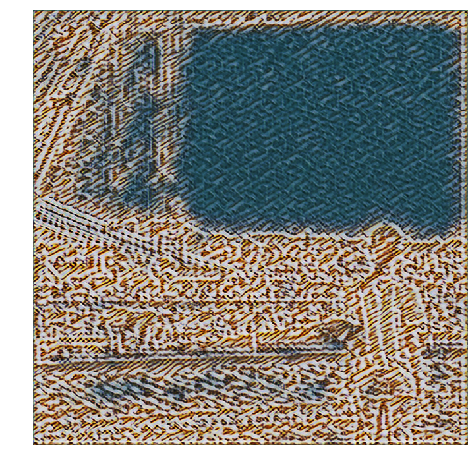

In [0]:
#@title Model building
import keras
from PIL import Image
from matplotlib import pyplot
import requests
from io import BytesIO
import numpy
from IPython.display import Markdown



def download_image(image_url):
    response = requests.get(image_url)
    return PIL.Image.open(BytesIO(response.content))


# def run_prediction(model, image, image_size):
    # image = image.resize(image_size)
    # input_data = numpy.zeros(image)[:, :, :3] - 120.0
    # output_data = model.predict(input_data)
    # return PIL.Image.fromarray(output_data[0].astype('uint8'))

def run_prediction(model, image, image_size):
    image = image.resize(image_size)
    input_data = numpy.array(image)[None, :, :, :3]
    output_data = model.predict(input_data)
    return PIL.Image.fromarray(output_data[0].astype('uint8'))
  
keras.backend.clear_session()
# Load the model
#image_size = (640,540)[0:2] #@param {type:"raw"}
image_size = (660,660)
model = StyleTransferNetwork.build(
    image_size,
    alpha=0.25, 
    checkpoint_file='style.h5'
)

#@title Stylize an Image!
# image_url = 'https://www.cdqzsta.com/wp-content/uploads/2019/08/l01.jpg' #@param {type:"string"}
image = download_image(image_url)
# stylized_image = run_prediction(model, image, image_size)
stylized_image = run_prediction(model, image, image_size)

fig, ax = pyplot.subplots(1,1);
fig.set_size_inches(8, 8)
ax.axis('off')
ax.imshow(stylized_image);


这个 jupyter notebook 的实现离不开一众文章或开源软件的支持。它们的地址是：

1-[pytorch-book](https://github.com/chenyuntc/pytorch-book/tree/master/chapter8-%E9%A3%8E%E6%A0%BC%E8%BF%81%E7%A7%BB(Neural%20Style))（我们一开始就是想使用 fastai 和 pytorch，但是由于 pytorch 新版本的发布导致了很多不兼容，我们最终没有用。）

2-[TensorFlow Models](https://github.com/tensorflow/models/blob/master/research/nst_blogpost/4_Neural_Style_Transfer_with_Eager_Execution.ipynb)(独立风格迁移实践，也可以在 colab 运行。)

3-[Keras](https://github.com/keras-team)（函数式API很棒。）

4-[Heartbeat](https://heartbeat.fritz.ai/reducing-coreml2-model-size-by-4x-with-quantization-in-ios12-b1c854651c4)（很重要的一篇文章，帮助我们极大降低了模型大小，同时我们甚至能够按照 TensorFlow 的文档将我们的模型迁移到 TensorFlow Lite 上。）
5-[MIT App Inventor](http://app.gzjkw.net)（我们居然还可以直接用这个工具加上一个连接到我们服务器的api来迅速创建一个 android app！！！）